# Adult Dataset Part 1

In [1]:
import xgboost
import shap
import numpy as np
import pandas as pd
import scipy.stats as stats
import copy
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
shap.initjs()

In [2]:
X,y = shap.datasets.adult(display=True)
X.rename(columns = {'Workclass':'Work Class', 'Education-Num':'Number of Years of Education', 
                    'Hours per week':'Hours Worked Per Week', 'Country':'Native Country',
                    'Relationship':'Role in Family'}, inplace = True)
X = pd.get_dummies(X, prefix_sep=':')
X.columns = [x.strip().replace('-', ' ') for x in X.columns]
X.rename(columns = {'Sex: Male':'Sex', 'Work Class: ?':'Work Class: Unknown', 'Occupation: ?':'Occupation: Unknown', 
                    'Marital Status: Married AF spouse':'Marital Status: Married to a spouse in the Armed Forces',
                    'Marital Status: Married civ spouse':'Marital Status: Married to a civilian spouse',
                    'Role in Family: Not in family':'Role in Family: Not in a family',
                    'Native Country: ?':'Native Country: Unknown', 
                    'Native Country: Outlying US(Guam USVI etc)':'Native Country: Outlying US (Guam, USVI, etc)', 
                    'Native Country: Trinadad&Tobago':'Native Country: Trinadad & Tobago'}, inplace = True)
X.drop(labels='Sex: Female', axis=1, inplace=True)
X_display = X.copy()
for col in X.columns:
    if any(v in col for v in ('Work Class: ', 'Marital Status: ', 'Occupation: ', 'Role in Family: ', 'Race: ', 'Native Country: ')):
        X_display[col] = ['Yes' if w==1.0 else 'No' for w in X_display[col]]
model = xgboost.XGBClassifier().fit(X, y)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap_values.display_data = X_display.values

 99%|===================| 32135/32561 [00:29<00:00]        

This dataset is derived from the Adult Income, or Census, dataset. It was collected by the Census Bureau in 1994. It is used to predict whether or not an individual made more than \\$50,000 USD in 1994, the equivalent of about \$88,000 today when adjusted for inflation.  
  
Task: Classification  
Outcome Variable: Whether an individual has an income <=50k (labeled as 0) or >50k (labeled as 1)  
Input Features:
- Age: a continuous number.
- Work Class: a categorical variable that has been one-hot encoded that represents different work sectors with values Federal employee, Private, Self emp not inc, Self emp inc, Federal gov, Local gov, State gov, Without pay, Never worked, Federal worker, Unknown.
- Number of Years of Education: a discrete value that represents the level of education. 0 is Preschool, 16 is Doctorate.
- Marital Status: a categorical variable that has been one-hot encoded with values Married to a civilian spouse, Divorced, Never married, Separated, Widowed, Married spouse absent, Married to a spouse in the Armed Forces.
- Occupation: a categorical variable that has been one-hot encoded with values Tech support, Craft repair, Other service, Sales, Exec managerial, Prof specialty, Handlers cleaners, Machine op inspct, Adm clerical, Farming fishing, Transport moving, Priv house serv, Protective serv, Armed Forces, Unknown.
- Role in Family: a categorical variable that has been one-hot encoded that represents the role an individual has within their family with values Husband, Not in a family, Other relative, Own child, Unmarried, Wife.
- Race: a categorical variable that has been one-hot encoded with values White, Asian Pac Islander, Amer Indian Eskimo, Other, Black.
- Sex: a binary variable for the individual's sex. 1 encodes male, 0 encodes female.
- Capital Gain: a continuous number of the amount of capital gains income reported to the IRS that year.
- Capital Loss: a continuous number of the amount of capital losses income reported to the IRS that year.
- Hours Worked Per Week: a continuous number of the number of hours the individual works per week on average.
- Native Country: a categorical variable that has been one-hot encoded including countries such as United-States, Cambodia, England, Puerto Rico, Canada, Germany, Outlying US (Guam, USVI, etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El Salvador, Trinadad & Tobago, Peru, Hong, Holand Netherlands, Unknown.  
  
Using this dataset, we built a gradient boosted tree model that predicts whether someone has an income of <=50k (class 0) or >50k (class 1). We split the predictions into classes 0 and 1 at the 0.5 threshold of probability.  We then explain this model's output using SHAP.

In [3]:
X.describe()

,Age,Number of Years of Education,Capital Gain,Capital Loss,Hours Worked Per Week,Work Class: Unknown,Work Class: Federal gov,Work Class: Local gov,Work Class: Never worked,Work Class: Private,Work Class: Self emp inc,Work Class: Self emp not inc,Work Class: State gov,Work Class: Without pay,Marital Status: Divorced,Marital Status: Married to a spouse in the Armed Forces,Marital Status: Married to a civilian spouse,Marital Status: Married spouse absent,Marital Status: Never married,Marital Status: Separated,Marital Status: Widowed,Occupation: Unknown,Occupation: Adm clerical,Occupation: Armed Forces,Occupation: Craft repair,Occupation: Exec managerial,Occupation: Farming fishing,Occupation: Handlers cleaners,Occupation: Machine op inspct,Occupation: Other service,Occupation: Priv house serv,Occupation: Prof specialty,Occupation: Protective serv,Occupation: Sales,Occupation: Tech support,Occupation: Transport moving,Role in Family: Husband,Role in Family: Not in a family,Role in Family: Other relative,Role in Family: Own child,Role in Family: Unmarried,Role in Family: Wife,Race: Amer Indian Eskimo,Race: Asian Pac Islander,Race: Black,Race: Other,Race: White,Sex,Native Country: Unknown,Native Country: Cambodia,Native Country: Canada,Native Country: China,Native Country: Columbia,Native Country: Cuba,Native Country: Dominican Republic,Native Country: Ecuador,Native Country: El Salvador,Native Country: England,Native Country: France,Native Country: Germany,Native Country: Greece,Native Country: Guatemala,Native Country: Haiti,Native Country: Holand Netherlands,Native Country: Honduras,Native Country: Hong,Native Country: Hungary,Native Country: India,Native Country: Iran,Native Country: Ireland,Native Country: Italy,Native Country: Jamaica,Native Country: Japan,Native Country: Laos,Native Country: Mexico,Native Country: Nicaragua,"Native Country: Outlying US (Guam, USVI, etc)",Native Country: Peru,Native Country: Philippines,Native Country: Poland,Native Country: Portugal,Native Country: Puerto Rico,Native Country: Scotland,Native Country: South,Native Country: Taiwan,Native Country: Thailand,Native Country: Trinadad & Tobago,Native Country: United States,Native Country: Vietnam,Native Country: Yugoslavia
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.0000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581646,10.080679,1077.648804,87.303833,40.437454,0.056386,0.029483,0.064279,0.000215,0.697030,0.034274,0.078038,0.039864,0.000430,0.136452,0.000706,0.459937,0.012837,0.328092,0.031479,0.030497,0.056601,0.115783,0.000276,0.125887,0.124873,0.030527,0.042075,0.061485,0.101195,0.004576,0.127146,0.019932,0.112097,0.0285,0.049046,0.405178,0.255060,0.030128,0.155646,0.105832,0.048156,0.009551,0.031909,0.095943,0.008323,0.854274,0.669205,0.017905,0.000584,0.003716,0.002303,0.001812,0.002918,0.002150,0.000860,0.003255,0.002764,0.000891,0.004207,0.000891,0.001966,0.001351,0.000031

# Global Feature Importance Bar Plots

### Mean Absolute Value

**How it's Calculated:** Mean over all samples in the training data set of the absolute value of each sample's model attribution score.  
**Potential Uses:** Gives a sense of what the model is learning overall. Currently the default global feature importance ranking in SHAP.

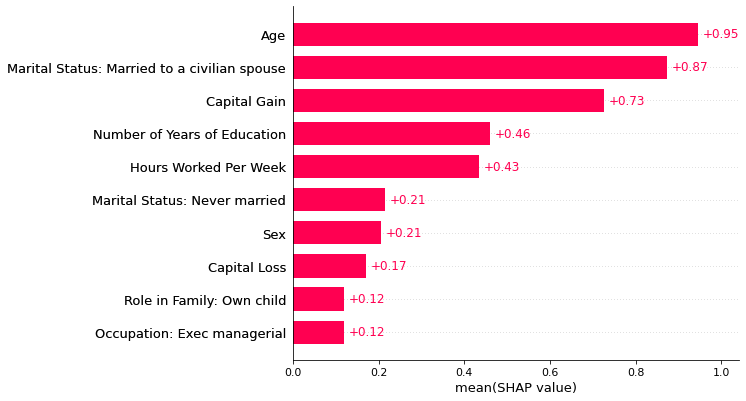

In [4]:
shap.plots.bar(shap_values)

# Global Feature Importance Summary Plot

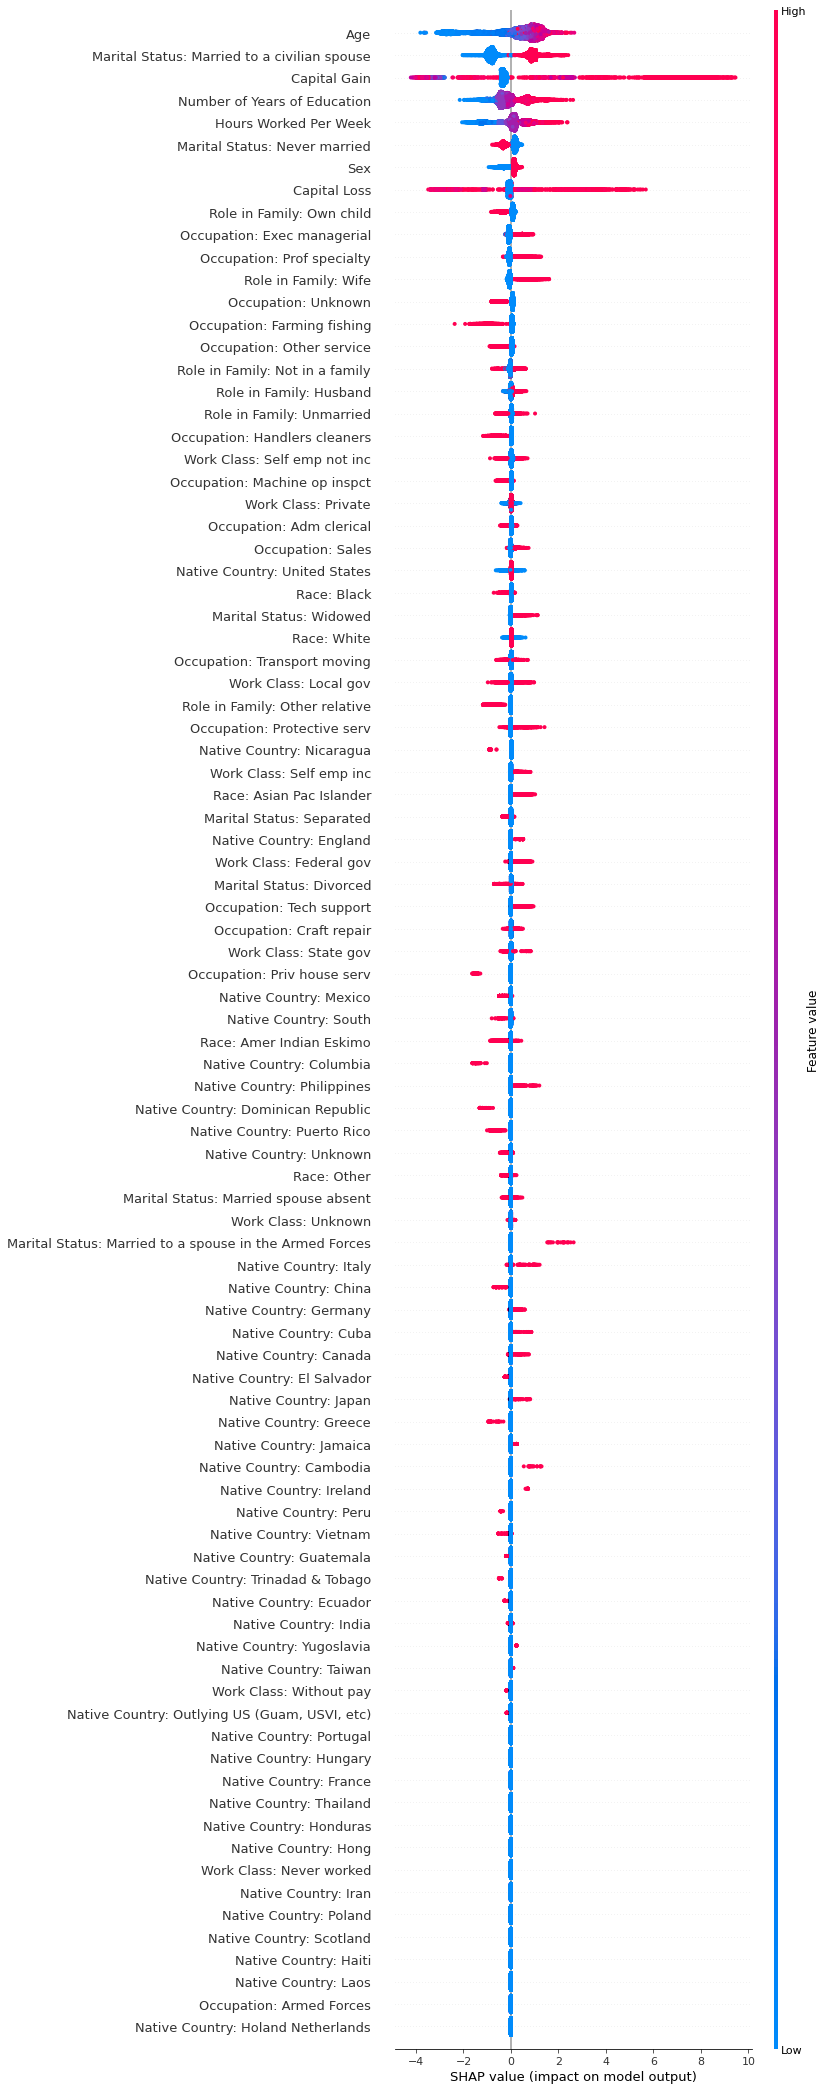

In [8]:
shap.plots.beeswarm(shap_values)

# Individual Feature Dependence Plots

#### Age

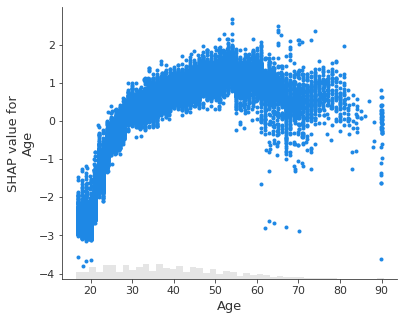

In [9]:
shap.plots.scatter(shap_values[:,'Age'])

#### Capital Gain

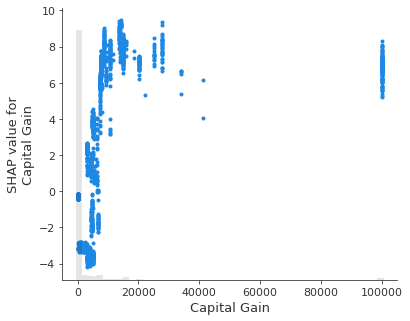

In [10]:
shap.plots.scatter(shap_values[:,'Capital Gain'])

#### Capital Loss

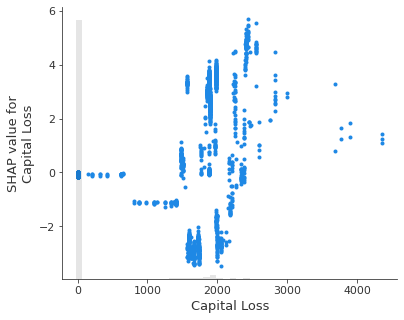

In [11]:
shap.plots.scatter(shap_values[:,'Capital Loss'])

#### Hours Worked Per Week

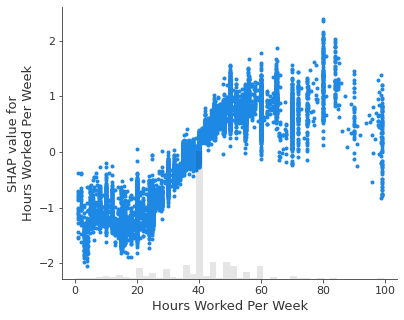

In [12]:
shap.plots.scatter(shap_values[:,'Hours Worked Per Week'])

#### Marital Status

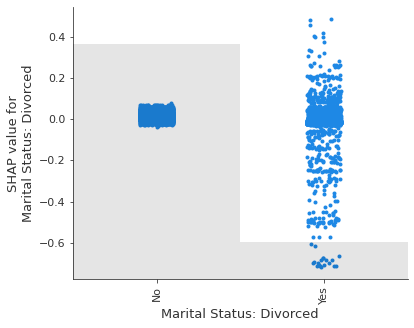

In [13]:
shap.plots.scatter(shap_values[:,'Marital Status: Divorced'])

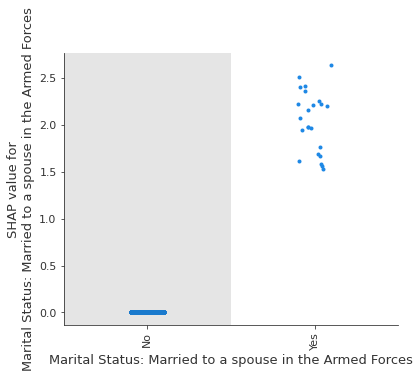

In [14]:
shap.plots.scatter(shap_values[:,'Marital Status: Married to a spouse in the Armed Forces'])

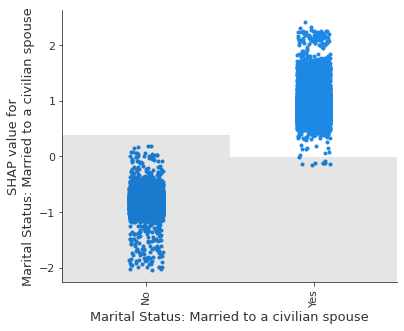

In [15]:
shap.plots.scatter(shap_values[:,'Marital Status: Married to a civilian spouse'])

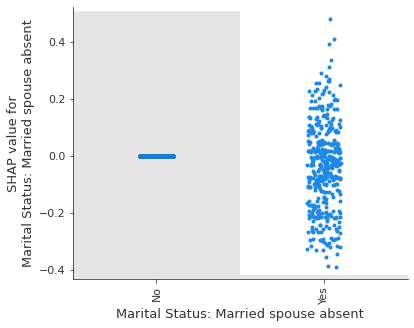

In [16]:
shap.plots.scatter(shap_values[:,'Marital Status: Married spouse absent'])

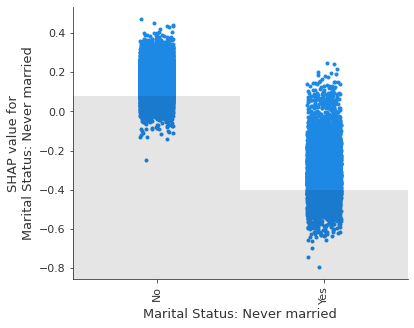

In [17]:
shap.plots.scatter(shap_values[:,'Marital Status: Never married'])

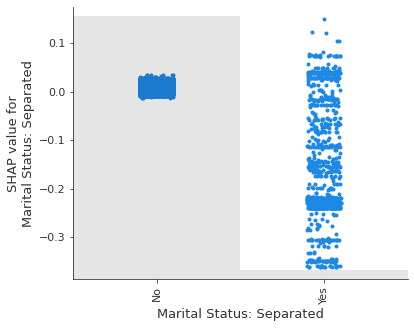

In [18]:
shap.plots.scatter(shap_values[:,'Marital Status: Separated'])

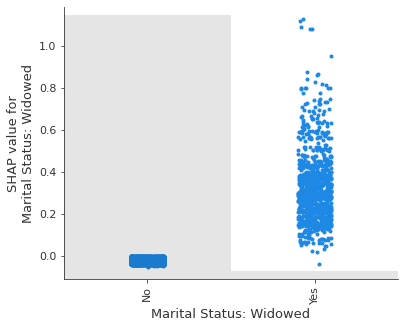

In [19]:
shap.plots.scatter(shap_values[:,'Marital Status: Widowed'])

#### Native Country

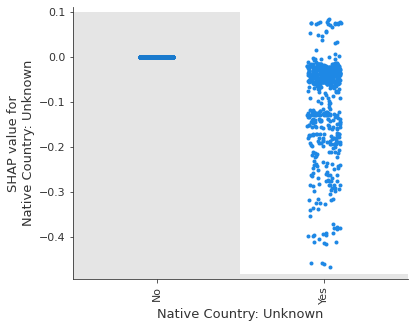

In [20]:
shap.plots.scatter(shap_values[:,'Native Country: Unknown'])

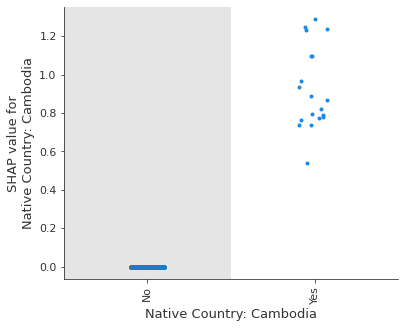

In [21]:
shap.plots.scatter(shap_values[:,'Native Country: Cambodia'])

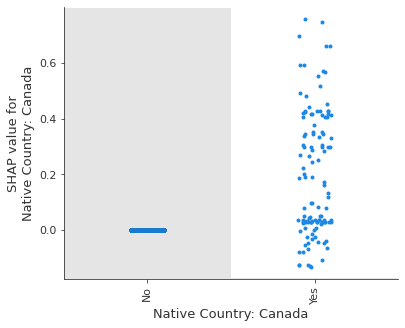

In [22]:
shap.plots.scatter(shap_values[:,'Native Country: Canada'])

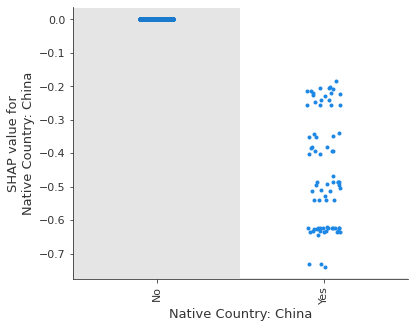

In [23]:
shap.plots.scatter(shap_values[:,'Native Country: China'])

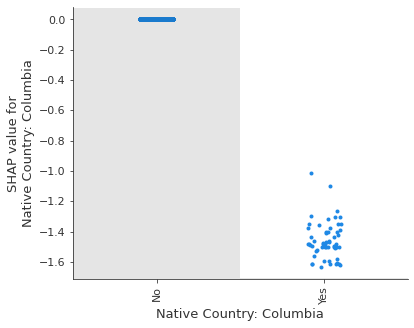

In [24]:
shap.plots.scatter(shap_values[:,'Native Country: Columbia'])

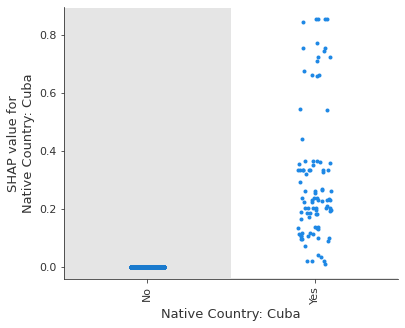

In [25]:
shap.plots.scatter(shap_values[:,'Native Country: Cuba'])

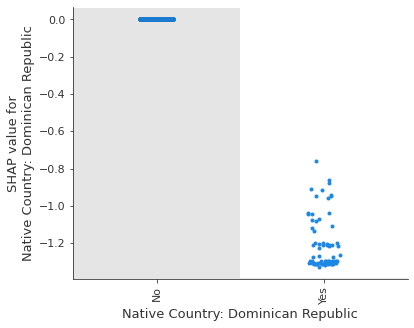

In [26]:
shap.plots.scatter(shap_values[:,'Native Country: Dominican Republic'])

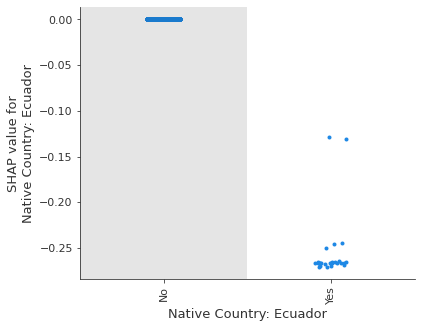

In [27]:
shap.plots.scatter(shap_values[:,'Native Country: Ecuador'])

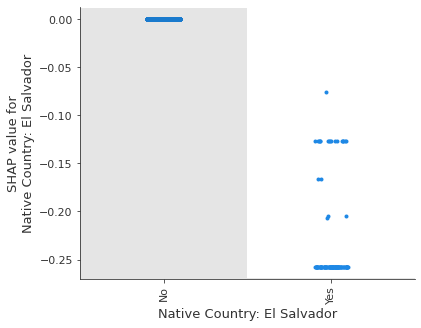

In [28]:
shap.plots.scatter(shap_values[:,'Native Country: El Salvador'])

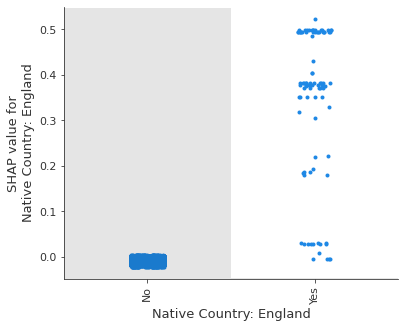

In [29]:
shap.plots.scatter(shap_values[:,'Native Country: England'])

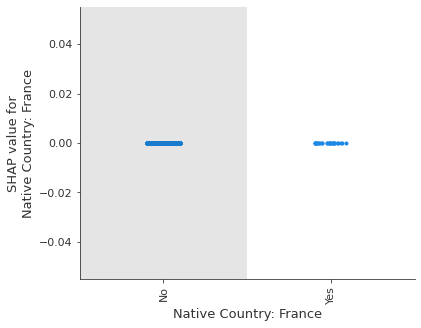

In [30]:
shap.plots.scatter(shap_values[:,'Native Country: France'])

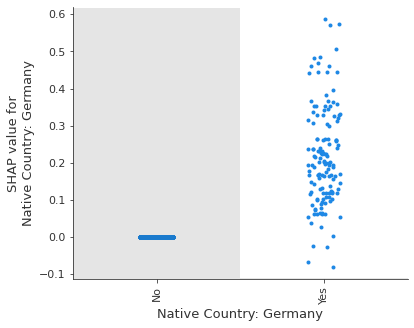

In [31]:
shap.plots.scatter(shap_values[:,'Native Country: Germany'])

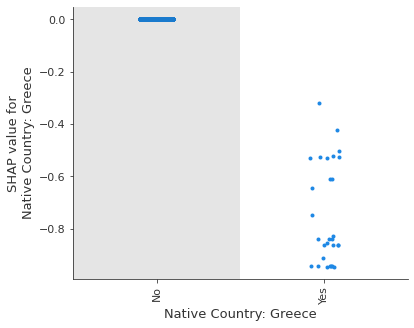

In [32]:
shap.plots.scatter(shap_values[:,'Native Country: Greece'])

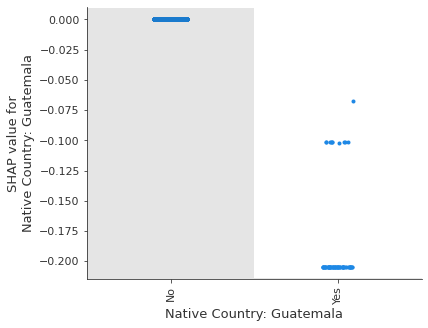

In [33]:
shap.plots.scatter(shap_values[:,'Native Country: Guatemala'])

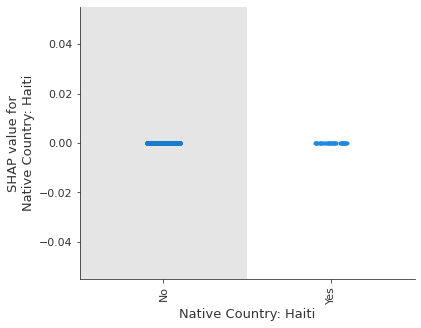

In [34]:
shap.plots.scatter(shap_values[:,'Native Country: Haiti'])

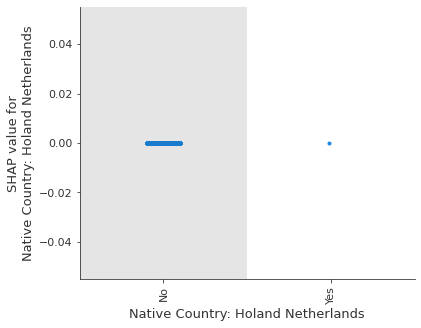

In [35]:
shap.plots.scatter(shap_values[:,'Native Country: Holand Netherlands'])

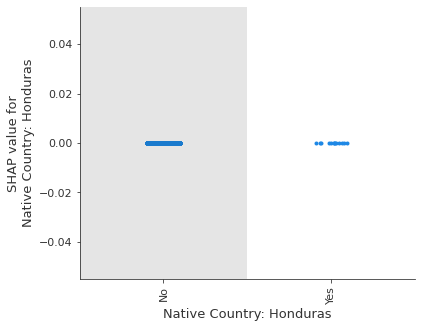

In [36]:
shap.plots.scatter(shap_values[:,'Native Country: Honduras'])

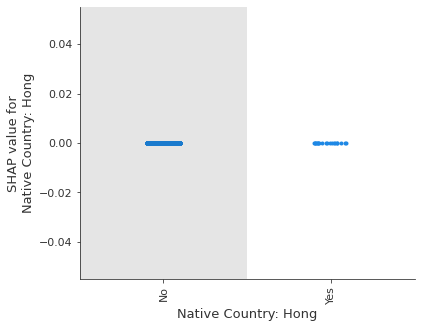

In [37]:
shap.plots.scatter(shap_values[:,'Native Country: Hong'])

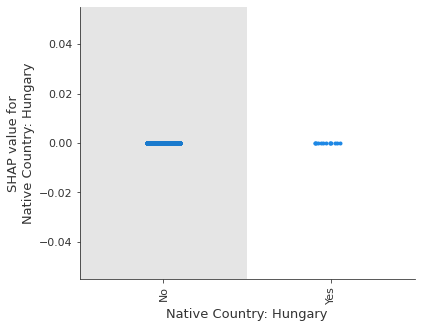

In [38]:
shap.plots.scatter(shap_values[:,'Native Country: Hungary'])

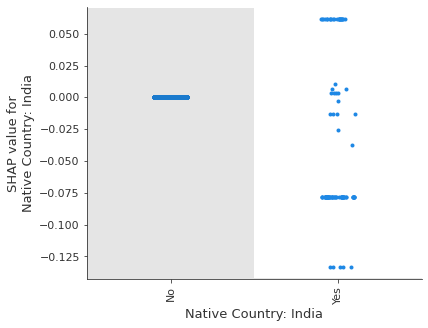

In [39]:
shap.plots.scatter(shap_values[:,'Native Country: India'])

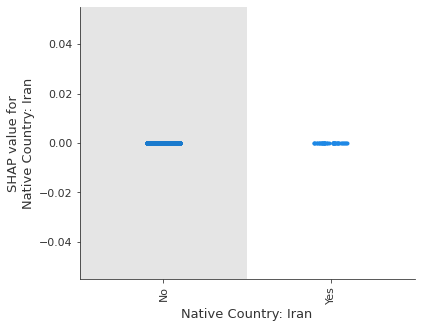

In [40]:
shap.plots.scatter(shap_values[:,'Native Country: Iran'])

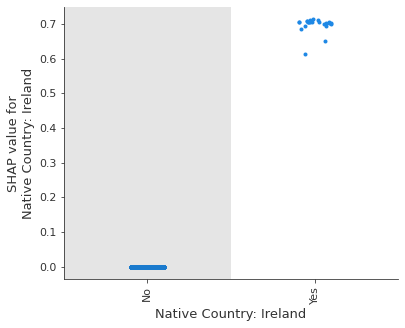

In [41]:
shap.plots.scatter(shap_values[:,'Native Country: Ireland'])

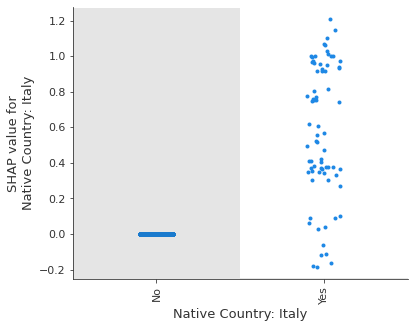

In [42]:
shap.plots.scatter(shap_values[:,'Native Country: Italy'])

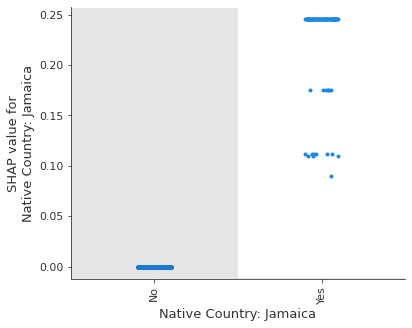

In [43]:
shap.plots.scatter(shap_values[:,'Native Country: Jamaica'])

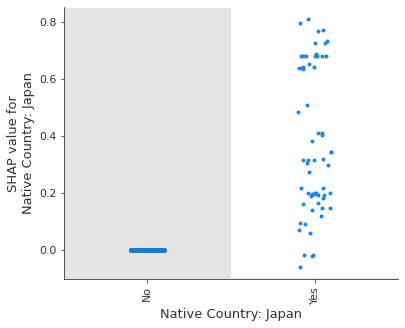

In [44]:
shap.plots.scatter(shap_values[:,'Native Country: Japan'])

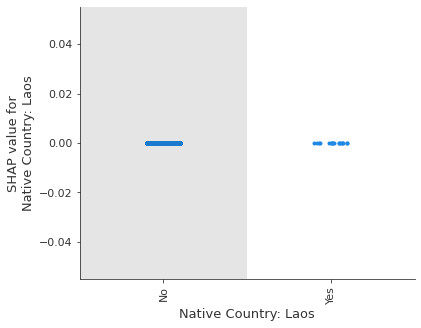

In [45]:
shap.plots.scatter(shap_values[:,'Native Country: Laos'])

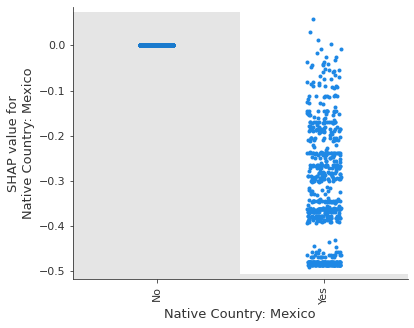

In [46]:
shap.plots.scatter(shap_values[:,'Native Country: Mexico'])

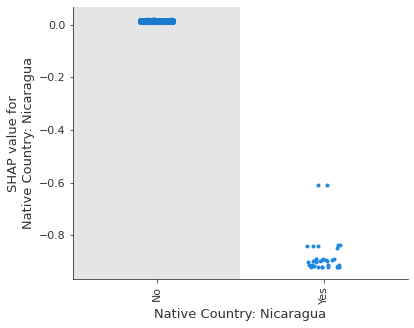

In [47]:
shap.plots.scatter(shap_values[:,'Native Country: Nicaragua'])

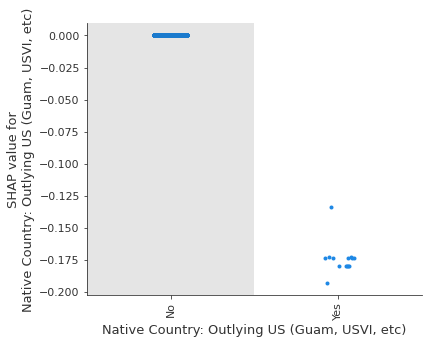

In [48]:
shap.plots.scatter(shap_values[:,'Native Country: Outlying US (Guam, USVI, etc)'])

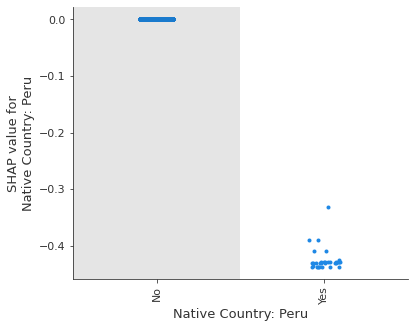

In [49]:
shap.plots.scatter(shap_values[:,'Native Country: Peru'])

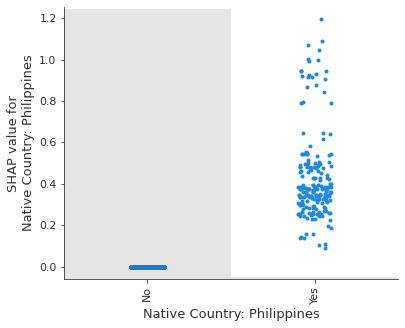

In [50]:
shap.plots.scatter(shap_values[:,'Native Country: Philippines'])

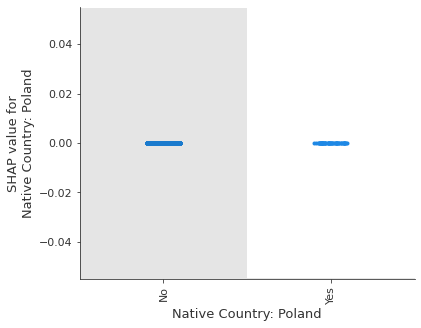

In [51]:
shap.plots.scatter(shap_values[:,'Native Country: Poland'])

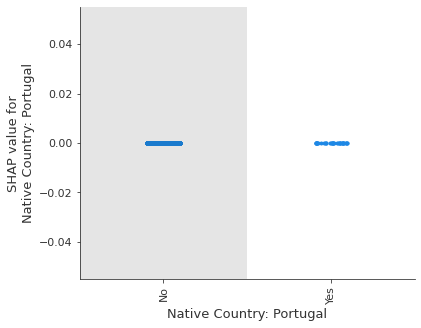

In [52]:
shap.plots.scatter(shap_values[:,'Native Country: Portugal'])

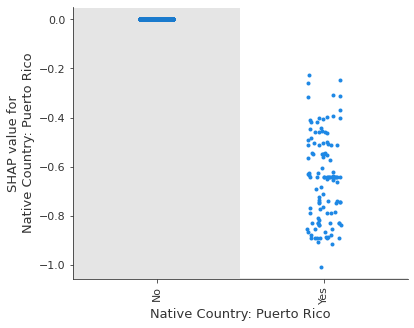

In [53]:
shap.plots.scatter(shap_values[:,'Native Country: Puerto Rico'])

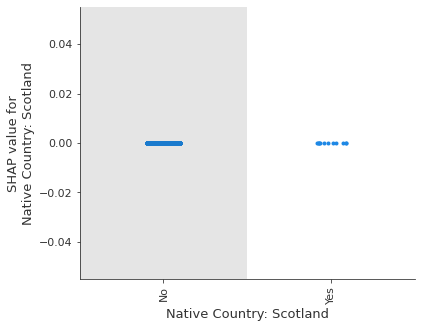

In [54]:
shap.plots.scatter(shap_values[:,'Native Country: Scotland'])

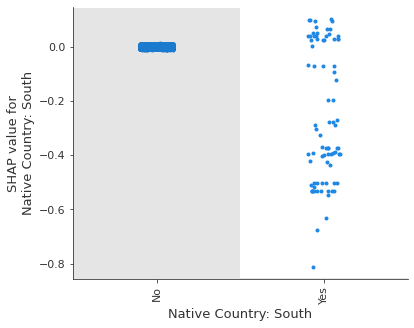

In [55]:
shap.plots.scatter(shap_values[:,'Native Country: South'])

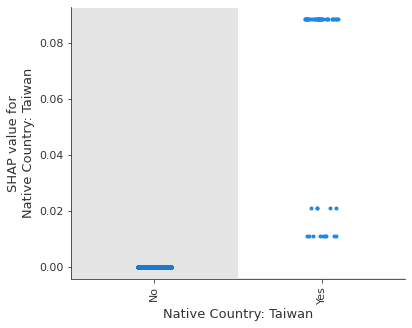

In [56]:
shap.plots.scatter(shap_values[:,'Native Country: Taiwan'])

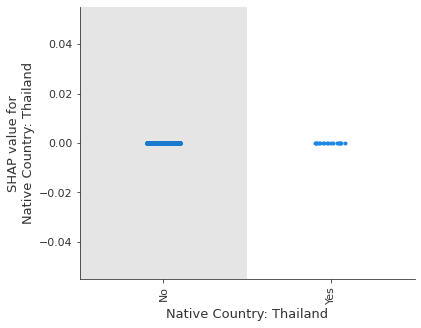

In [57]:
shap.plots.scatter(shap_values[:,'Native Country: Thailand'])

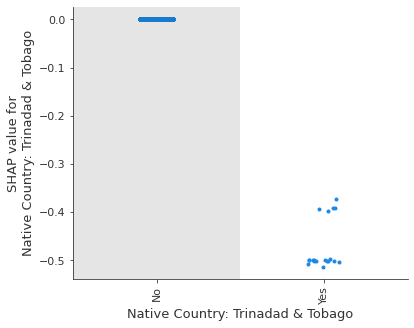

In [58]:
shap.plots.scatter(shap_values[:,'Native Country: Trinadad & Tobago'])

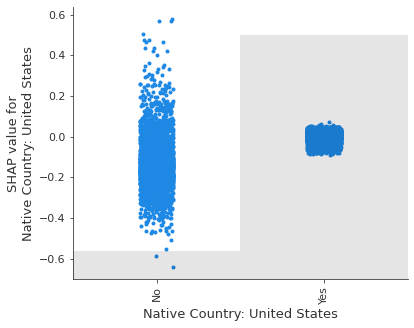

In [59]:
shap.plots.scatter(shap_values[:,'Native Country: United States'])

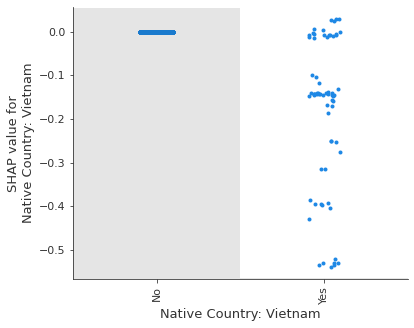

In [60]:
shap.plots.scatter(shap_values[:,'Native Country: Vietnam'])

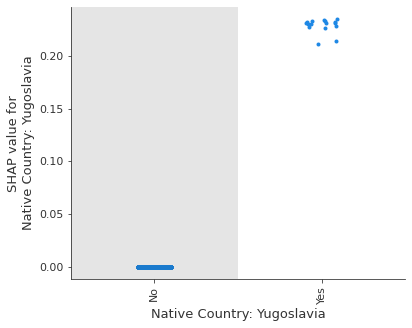

In [61]:
shap.plots.scatter(shap_values[:,'Native Country: Yugoslavia'])

#### Number of Years of Education

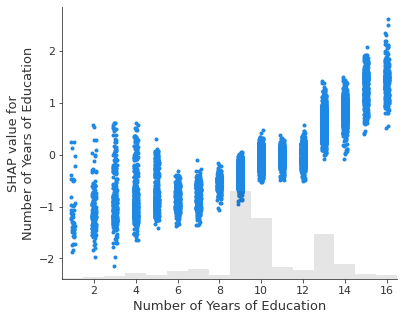

In [62]:
shap.plots.scatter(shap_values[:,'Number of Years of Education'])

#### Occupation

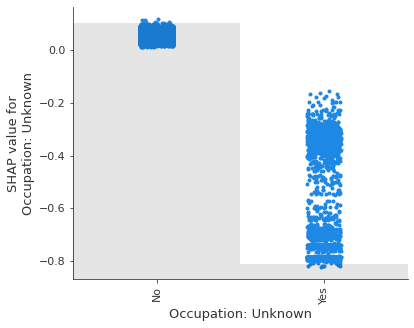

In [63]:
shap.plots.scatter(shap_values[:,'Occupation: Unknown'])

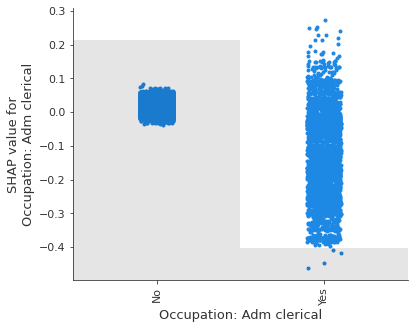

In [64]:
shap.plots.scatter(shap_values[:,'Occupation: Adm clerical'])

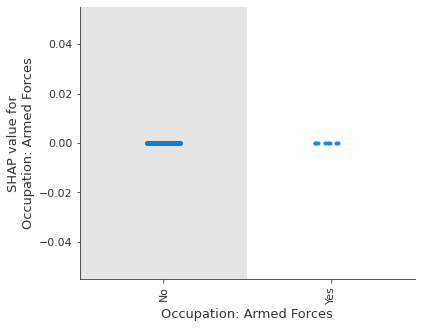

In [65]:
shap.plots.scatter(shap_values[:,'Occupation: Armed Forces'])

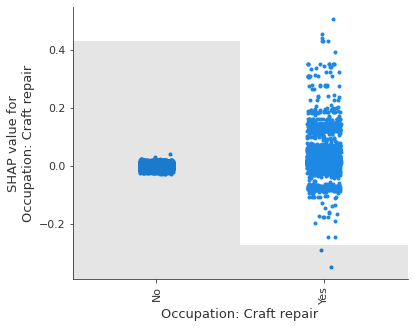

In [66]:
shap.plots.scatter(shap_values[:,'Occupation: Craft repair'])

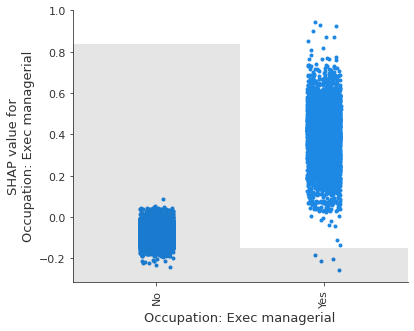

In [67]:
shap.plots.scatter(shap_values[:,'Occupation: Exec managerial'])

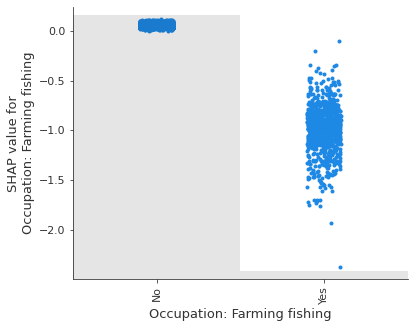

In [68]:
shap.plots.scatter(shap_values[:,'Occupation: Farming fishing'])

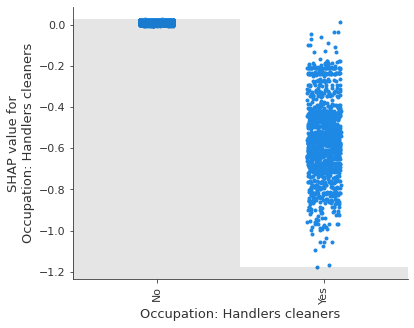

In [69]:
shap.plots.scatter(shap_values[:,'Occupation: Handlers cleaners'])

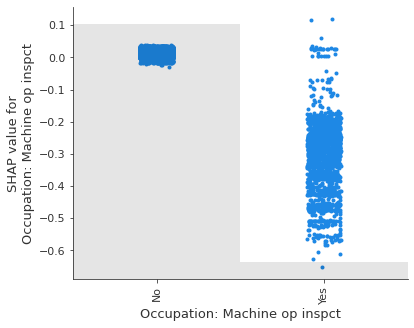

In [70]:
shap.plots.scatter(shap_values[:,'Occupation: Machine op inspct'])

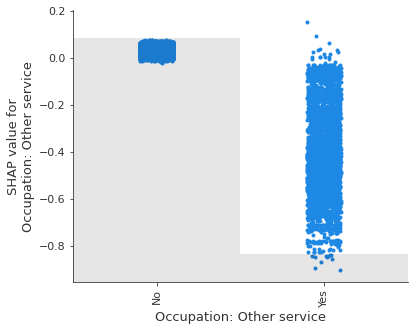

In [71]:
shap.plots.scatter(shap_values[:,'Occupation: Other service'])

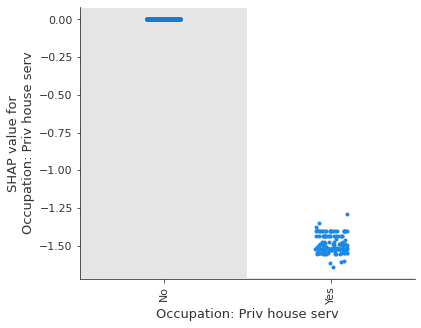

In [72]:
shap.plots.scatter(shap_values[:,'Occupation: Priv house serv'])

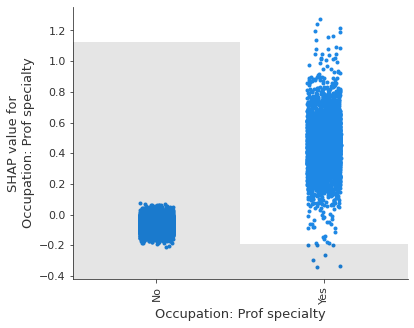

In [73]:
shap.plots.scatter(shap_values[:,'Occupation: Prof specialty'])

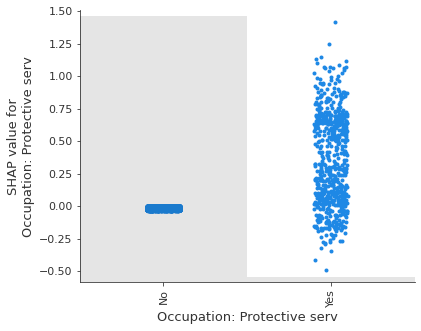

In [74]:
shap.plots.scatter(shap_values[:,'Occupation: Protective serv'])

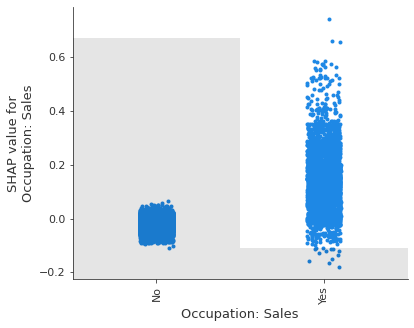

In [75]:
shap.plots.scatter(shap_values[:,'Occupation: Sales'])

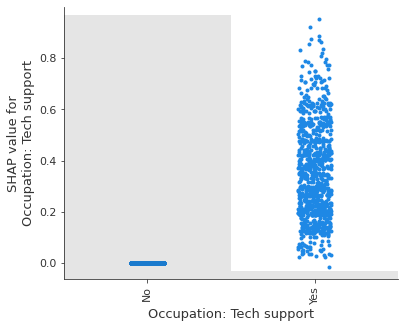

In [76]:
shap.plots.scatter(shap_values[:,'Occupation: Tech support'])

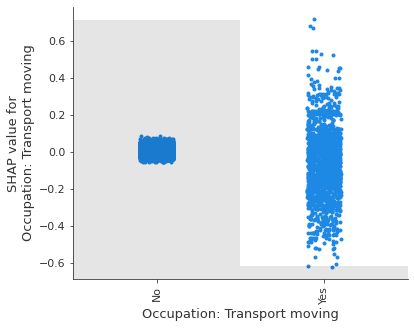

In [77]:
shap.plots.scatter(shap_values[:,'Occupation: Transport moving'])

#### Race

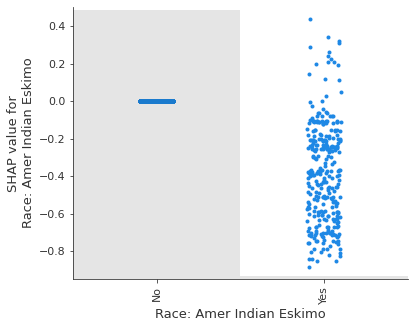

In [78]:
shap.plots.scatter(shap_values[:,'Race: Amer Indian Eskimo'])

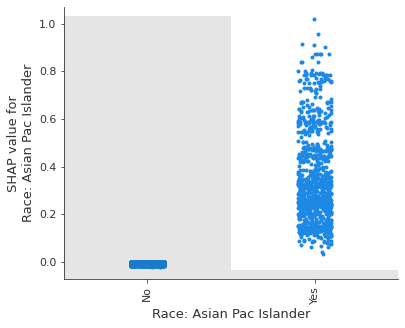

In [79]:
shap.plots.scatter(shap_values[:,'Race: Asian Pac Islander'])

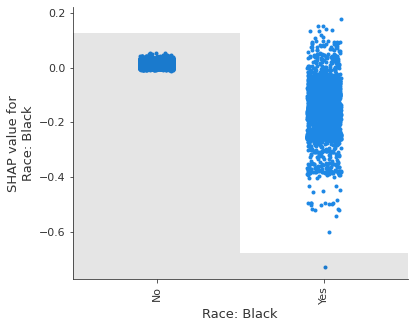

In [80]:
shap.plots.scatter(shap_values[:,'Race: Black'])

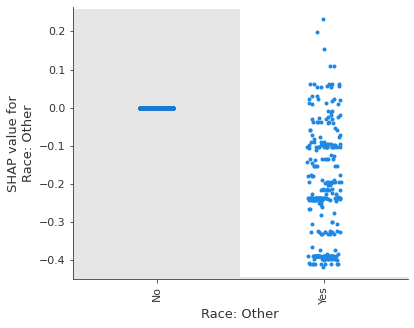

In [81]:
shap.plots.scatter(shap_values[:,'Race: Other'])

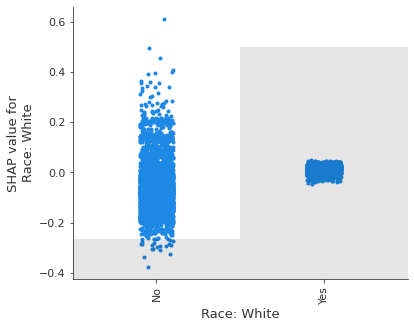

In [82]:
shap.plots.scatter(shap_values[:,'Race: White'])

#### Role in Family

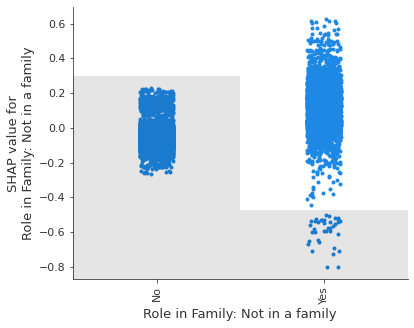

In [83]:
shap.plots.scatter(shap_values[:,'Role in Family: Not in a family'])

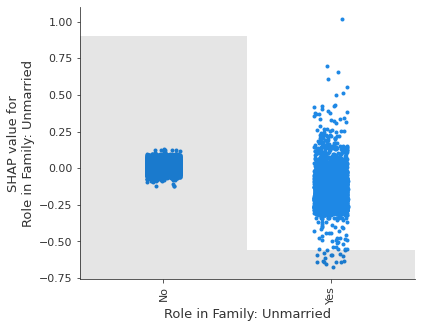

In [84]:
shap.plots.scatter(shap_values[:,'Role in Family: Unmarried'])

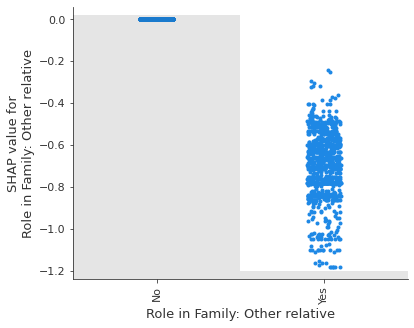

In [85]:
shap.plots.scatter(shap_values[:,'Role in Family: Other relative'])

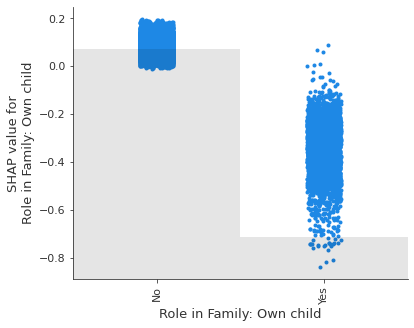

In [86]:
shap.plots.scatter(shap_values[:,'Role in Family: Own child'])

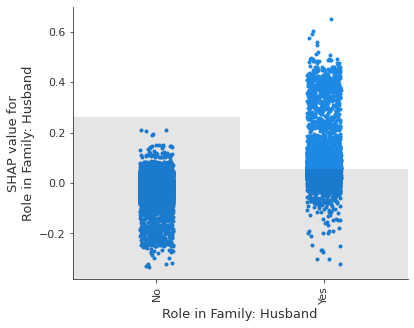

In [87]:
shap.plots.scatter(shap_values[:,'Role in Family: Husband'])

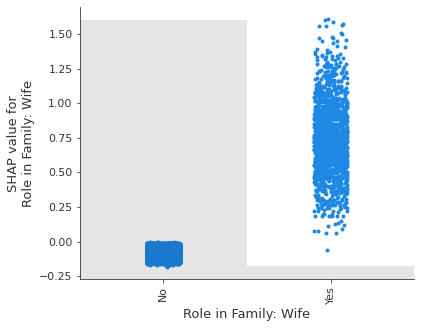

In [88]:
shap.plots.scatter(shap_values[:,'Role in Family: Wife'])

#### Sex

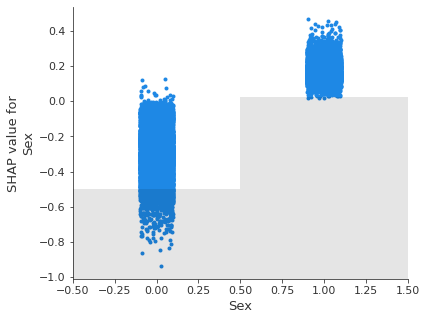

In [89]:
shap.plots.scatter(shap_values[:,'Sex'])

#### Work Class

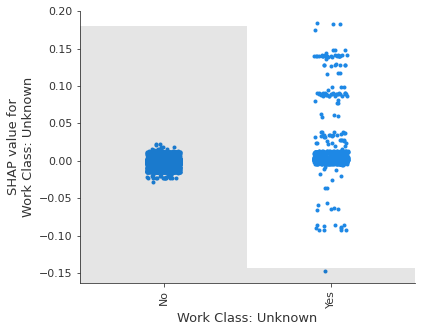

In [90]:
shap.plots.scatter(shap_values[:,'Work Class: Unknown'])

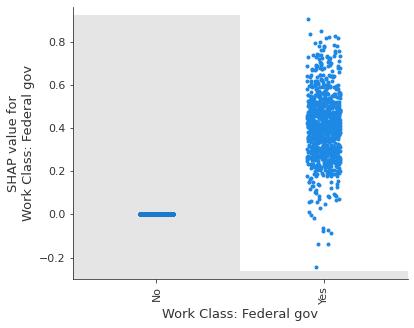

In [91]:
shap.plots.scatter(shap_values[:,'Work Class: Federal gov'])

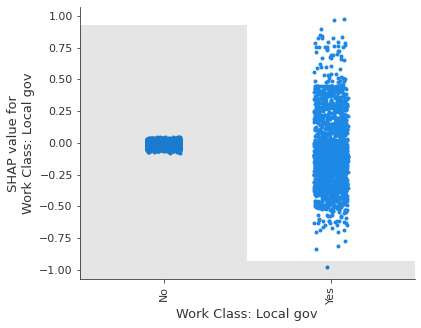

In [92]:
shap.plots.scatter(shap_values[:,'Work Class: Local gov'])

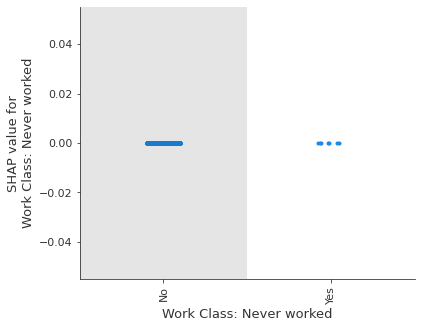

In [93]:
shap.plots.scatter(shap_values[:,'Work Class: Never worked'])

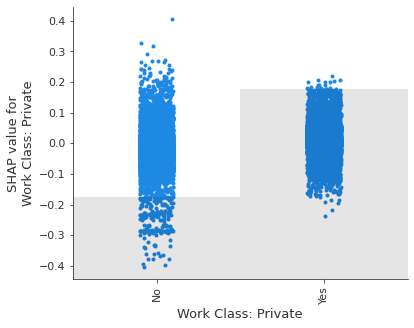

In [94]:
shap.plots.scatter(shap_values[:,'Work Class: Private'])

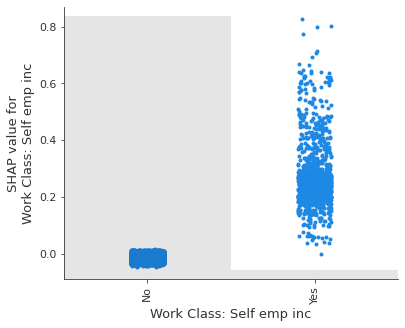

In [95]:
shap.plots.scatter(shap_values[:,'Work Class: Self emp inc'])

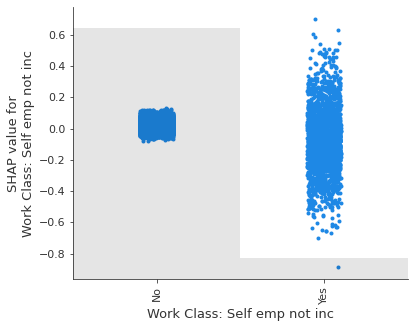

In [96]:
shap.plots.scatter(shap_values[:,'Work Class: Self emp not inc'])

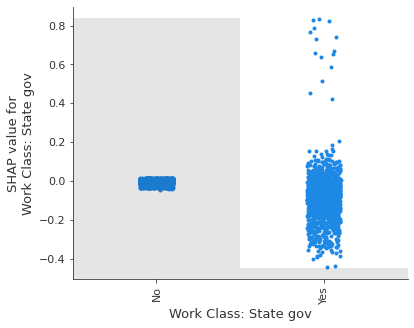

In [97]:
shap.plots.scatter(shap_values[:,'Work Class: State gov'])

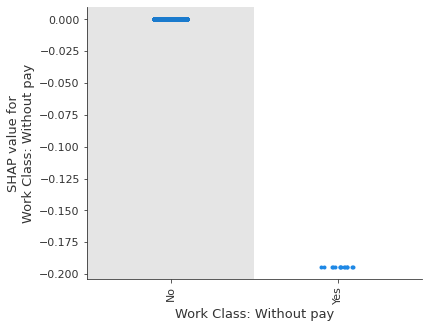

In [98]:
shap.plots.scatter(shap_values[:,'Work Class: Without pay'])